In [1]:
import torch
import torchvision
import torchvision.transforms.v2 as transformers

import numpy as np
import pandas as pd
import seaborn as sns

from transformers import CLIPModel
from transformers import AutoProcessor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import OrderedDict

/Users/Mikolaj/miniconda3/envs/EDS4AI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from EDFunctions import *

In [3]:
images, targets = get_ciafar10_data()


/Users/Mikolaj/miniconda3/envs/EDS4AI/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [4]:
image_embeddings = np.load('2d_embeddings.npy')

In [5]:
image_embeddings_slice = image_embeddings[:1000][:][:][:]

In [6]:
distances = calc_distances(image_embeddings_slice)
sorted_distances = sort_distances(distances)

In [7]:
batch_size = 100
batch_indexes = generate_indexes_proportional(image_embeddings_slice, sorted_distances, batch_size)

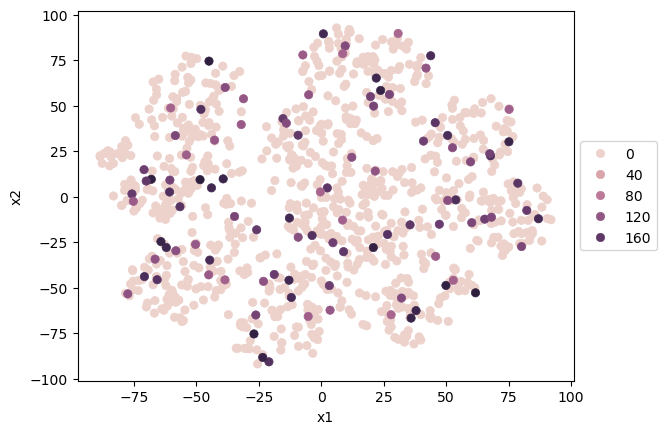

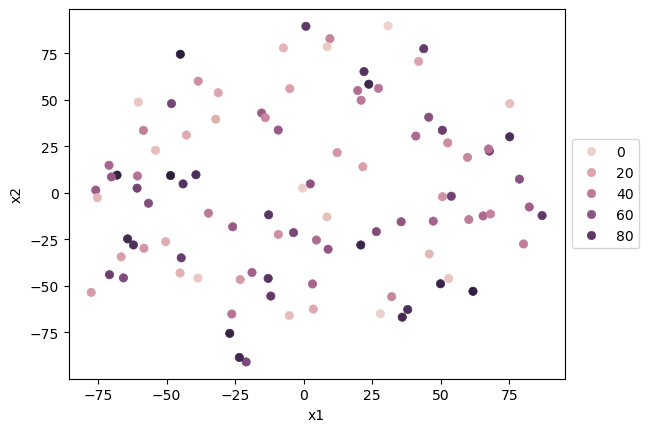

<class 'matplotlib.figure.Figure'>


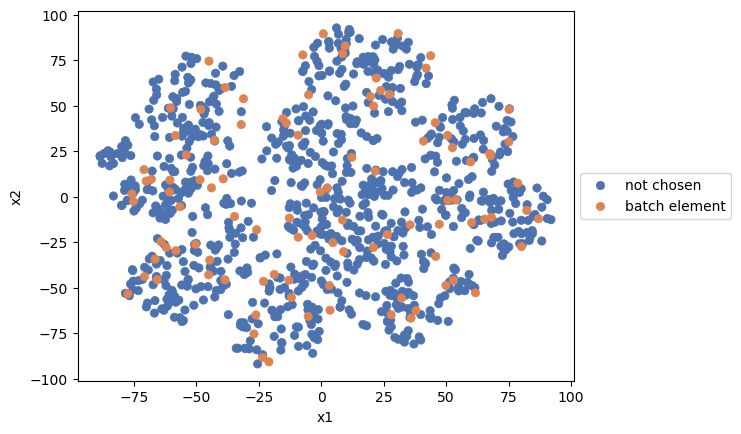

In [13]:
fig1 = plot_batch_order(image_embeddings_slice, batch_indexes, batch_size, type='inclusive')
#plt.close()
plt.show()
fig2 = plot_batch_order(image_embeddings_slice, batch_indexes, batch_size, type='exclusive')
#plt.close()
plt.show()
fig3 = plot_batch_elements(image_embeddings_slice,batch_indexes)
print(type(fig2))
plt.show()

In [9]:

column_vals = ['x1', 'x2']

df = pd.DataFrame(data = image_embeddings_slice, columns=column_vals)

m = image_embeddings_slice.shape[0]
chosen = ['not chosen' for x in range(m)]
for indx in batch_indexes:
    chosen[indx] = 'batch element'

df['label'] = chosen

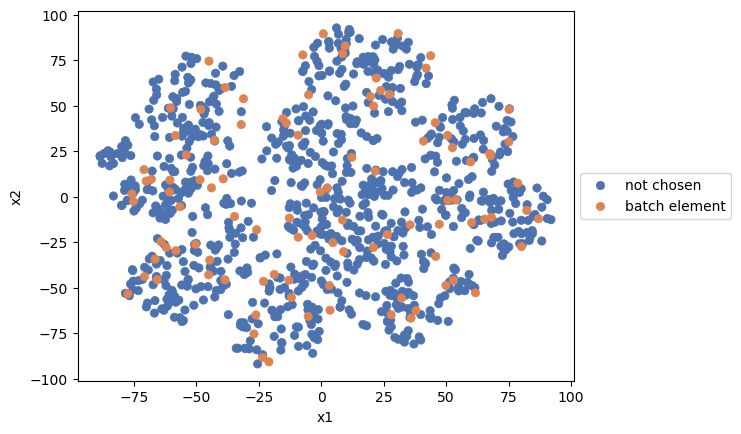

In [10]:

hue_order = ['not chosen', 'batch element']
df_sorted = df.sort_values('label', key=np.vectorize(hue_order.index))

plot = sns.scatterplot(x='x1', y='x2', data=df_sorted, hue='label', ec=None, palette="deep")
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

10


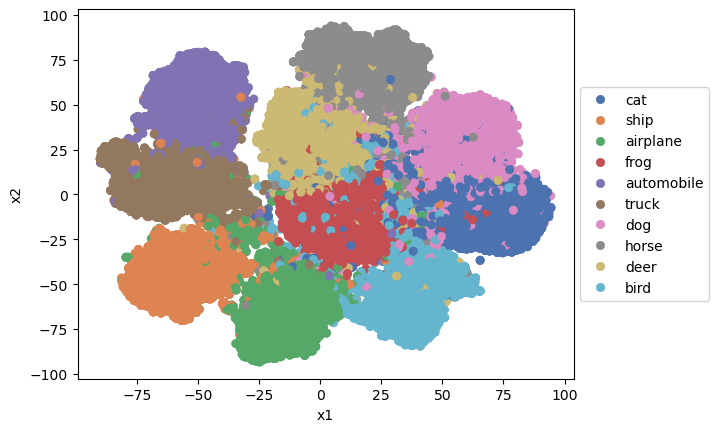

In [11]:
b = plot_classes_2d(image_embeddings, targets)
